# Close cross Ema - Strategy - Backtesting 

### Import Library

In [22]:
import numpy as np
import pandas as pd
import numpy as np
import pandas_ta as ta
from backtesting.backtesting import Backtest, Strategy

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 120
import warnings
warnings.filterwarnings('ignore')
# from backtesting._plotting import set_bokeh_output
# set_bokeh_output(notebook=False)
# from backtesting import set_bokeh_output
# set_bokeh_output(notebook=False)

### Load Price Data

In [23]:
import os
from pathlib import Path
notebook_path = os.getcwd()
algo_dir = Path(notebook_path).parent.parent
csv_file = str(algo_dir) + '/vn-stock-data/VN30ps/VN30F1M_5minutes.csv'
is_file = os.path.isfile(csv_file)
if is_file:
    dataset = pd.read_csv(csv_file, index_col='Date', parse_dates=True)
else:
    print('remote')
    dataset = pd.read_csv("https://raw.githubusercontent.com/zuongthaotn/vn-stock-data/main/VN30ps/VN30F1M_5minutes.csv", index_col='Date', parse_dates=True)

remote


In [24]:
data = dataset.copy()

In [25]:
# data = data[(data.index > '2020-11-01 00:00:00') & (data.index < '2024-10-01 00:00:00')]
data = data[data.index > '2020-11-01 00:00:00']

In [26]:
data

,Open,High,Low,Close,Volume
Date,,,,,
2020-11-02 09:00:00,900.1,900.2,899.3,900.1,1910
2020-11-02 09:05:00,900.2,900.2,898.7,899.4,1670
2020-11-02 09:10:00,899.5,900.0,899.0,899.5,1329
2020-11-02 09:15:00,899.4,899.5,898.2,898.6,1722
2020-11-02 09:20:00,898.5,898.6,896.5,898.2,2939
...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879


In [27]:
def get_signal(r):
    signal = ''
    if r['ema_fast_s1'] < r['ema_low_s1'] and r['ema_fast'] > r['ema_low'] and r['diff_cema'] < 12.5 and r['max_3xupper_wick'] < 1.65:
        signal = 'long'
    elif r['ema_fast_s1'] > r['ema_low_s1'] and r['ema_fast'] < r['ema_low'] and r['diff_cema'] > -9.5 and -2.55 < r['min_3xlower_shadow'] < 0.5 :
        signal = 'short'
    return signal

In [28]:
def prepare_data(data):
    data['max_in_range'] = data['High'].rolling(10).max()
    data['min_in_range'] = data['Low'].rolling(10).min()
    data["ema_fast"] = ta.ema(data["Close"], length=20)
    data["ema_low"] = ta.ema(data["Close"], length=250)
    data['ema_fast_s1'] = data['ema_fast'].shift(1)
    data['ema_low_s1'] = data['ema_low'].shift(1)
    data['diff_cema'] = data['Close'] - data['ema_low']
    data["body_size"] = abs(data["Close"] - data["Open"])
    data['lower_shadow'] = data.apply(lambda r: min(r['Close'], r['Open']) - r['Low'], axis=1)
    data['_3xlower_shadow'] = data.apply(lambda r: r['lower_shadow'] * r['lower_shadow'] * r['lower_shadow'] - r['body_size'], axis=1)
    data['min_3xlower_shadow'] = data['_3xlower_shadow'].rolling(3).min()
    data['upper_wick'] = data.apply(lambda r: r['High'] - max(r['Close'], r['Open']), axis=1)
    data['_3xupper_wick'] = data.apply(lambda r: r['upper_wick'] * r['upper_wick'] * r['upper_wick'] - r['body_size'], axis=1)
    data['max_3xupper_wick'] = data['_3xupper_wick'].rolling(3).max()
    data['signal'] = data.apply(lambda r: get_signal(r), axis=1)
    return data

In [29]:
prepared_data = prepare_data(data)
prepared_data.dropna(inplace=True)

In [30]:
prepared_data

,Open,High,Low,Close,Volume,max_in_range,min_in_range,ema_fast,ema_low,ema_fast_s1,ema_low_s1,diff_cema,body_size,lower_shadow,_3xlower_shadow,min_3xlower_shadow,upper_wick,_3xupper_wick,max_3xupper_wick,signal
Date,,,,,,,,,,,,,,,,,,,,
2020-11-06 14:15:00,911.0,912.7,910.5,910.6,5948,912.7,903.5,907.880896,908.796883,907.594675,908.782400,1.803117,0.4,0.1,-0.399,-2.875,1.7,4.513,4.513,
2020-11-06 14:20:00,910.7,911.2,909.4,910.9,4466,912.7,903.5,908.168430,908.813641,907.880896,908.796883,2.086359,0.2,1.3,1.997,-2.875,0.3,-0.173,4.513,
2020-11-06 14:25:00,910.5,911.0,908.5,910.0,3602,912.7,904.4,908.342865,908.823094,908.168430,908.813641,1.176906,0.5,1.5,2.875,-0.399,0.5,-0.375,4.513,
2020-11-06 14:30:00,910.5,910.7,910.5,910.7,78,912.7,906.2,908.567354,908.838049,908.342865,908.823094,1.861951,0.2,0.0,-0.200,-0.200,0.0,-0.200,-0.173,
2020-11-06 14:45:00,908.3,908.3,908.3,908.3,4462,912.7,906.7,908.541892,908.833762,908.567354,908.838049,-0.533762,0.0,0.0,0.000,-0.200,0.0,0.000,0.000,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-13 14:15:00,1333.5,1335.4,1333.4,1335.0,5583,1338.5,1333.4,1334.824575,1334.211764,1334.806109,1334.205432,0.788236,1.5,0.1,-1.499,-1.499,0.4,-1.436,-0.392,
2025-02-13 14:20:00,1335.4,1336.5,1334.7,1334.9,5753,1338.5,1333.4,1334.831758,1334.217248,1334.824575,1334.211764,0.682752,0.5,0.2,-0.492,-1.499,1.1,0.831,0.831,
2025-02-13 14:25:00,1335.3,1336.8,1334.9,1336.8,4879,1338.5,1333.4,1335.019210,1334.237827,1334.831758,1334.217248,2.562173,1.5,0.4,-1.436,-1.499,0.0,-1.500,0.831,


In [31]:
prepared_data[prepared_data.signal != ''].tail(20)

,Open,High,Low,Close,Volume,max_in_range,min_in_range,ema_fast,ema_low,ema_fast_s1,ema_low_s1,diff_cema,body_size,lower_shadow,_3xlower_shadow,min_3xlower_shadow,upper_wick,_3xupper_wick,max_3xupper_wick,signal
Date,,,,,,,,,,,,,,,,,,,,
2024-08-09 13:50:00,1256.5,1261.3,1256.5,1259.9,10812,1261.3,1249.2,1254.021839,1253.734840,1253.403086,1253.685321,6.165160,3.4,0.0,-3.400,-3.400,1.4,-0.656,0.728,long
2024-09-04 09:35:00,1313.9,1314.6,1313.8,1314.0,4665,1332.7,1310.5,1322.121501,1322.811181,1322.976395,1322.881954,-8.811181,0.1,0.1,-0.099,-0.875,0.6,0.116,0.116,short
2024-09-18 09:00:00,1305.0,1305.7,1304.0,1304.0,4270,1305.8,1288.0,1294.070130,1293.894196,1293.024880,1293.813024,10.105804,1.0,0.0,-1.000,-1.000,0.7,-0.657,0.000,long
2024-10-04 09:00:00,1351.7,1352.4,1349.6,1350.7,6529,1363.7,1349.0,1358.114510,1358.248046,1358.894985,1358.308672,-7.548046,1.0,1.1,0.331,0.000,0.7,-0.657,0.000,short
2024-10-09 13:00:00,1347.9,1353.8,1347.9,1352.9,13439,1353.8,1346.2,1347.497405,1347.492141,1346.928711,1347.448705,5.407859,5.0,0.0,-5.000,-5.000,0.9,-4.271,0.064,long
2024-10-22 09:30:00,1361.3,1362.0,1361.2,1361.6,3836,1364.7,1359.2,1363.030852,1363.138164,1363.181468,1363.150518,-1.538164,0.3,0.1,-0.299,-1.373,0.4,-0.236,0.116,short
2024-11-01 09:50:00,1337.0,1337.5,1336.5,1337.3,1609,1338.8,1336.4,1339.199980,1339.242278,1339.399978,1339.257879,-1.942278,0.3,0.5,-0.175,-0.284,0.2,-0.292,-0.173,short
2024-11-06 13:35:00,1331.0,1332.6,1330.1,1331.7,7697,1332.6,1325.9,1328.278631,1328.212243,1327.918487,1328.184229,3.487757,0.7,0.9,0.029,-2.036,0.9,0.029,0.243,long
2024-11-08 11:15:00,1329.0,1329.4,1327.8,1328.3,3600,1333.4,1327.8,1332.619107,1332.634868,1333.073749,1332.669686,-4.334868,0.7,0.5,-0.575,-0.675,0.4,-0.636,0.800,short


In [32]:
class MainStrategy(Strategy):
    max_sl = 3.1
    trailing_sl = 7
    tp_step = 27
    def init(self):
        self._broker._cash = 1500
        super().init()

    def next(self):
        super().next()
        
        close_price = self.data.Close[-1]
        if self.position.is_long:
            max_in_range = self.data.max_in_range[-1]
            if close_price < max_in_range - self.trailing_sl:
                self.position.close()
        elif self.position.is_short:
            min_in_range = self.data.min_in_range[-1]
            if close_price > min_in_range + self.trailing_sl:
                self.position.close()
        #
        _time = self.data.index
        current_time = _time[-1]
        if current_time.hour == 14 and current_time.minute >= 25:
            return
        #
        #
        # if self.position.is_long:
        #     ema_low = self.data.ema_low[-1]
        #     if close_price < ema_low:
        #         self.position.close()
        # elif self.position.is_short:
        #     ema_low = self.data.ema_low[-1]
        #     if close_price > ema_low:
        #         self.position.close()
        #
 
        signal = self.data.signal[-1]
        if self.position:
            if signal == 'long' and self.position.is_short:
                self.position.close()
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short' and self.position.is_long:
                sell_price = close_price
                self.position.close()
                sl = sell_price + self.max_sl
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)
        else:
            if signal == 'long':
                buy_price = close_price
                sl = buy_price - self.max_sl
                tp = buy_price + self.tp_step
                self.buy(size=1, sl=sl, tp=tp)
            elif signal == 'short':
                sell_price = close_price
                sl = sell_price + self.max_sl
                tp = sell_price - self.tp_step
                self.sell(size=1, sl=sl, tp=tp)

In [33]:
bt = Backtest(prepared_data, MainStrategy, commission=.0003, exclusive_orders=True)
stats = bt.run()

In [34]:
stats

Start                     2020-11-06 14:15:00
End                       2025-02-13 14:45:00
Duration                   1560 days 00:30:00
Exposure Time [%]                    16.43196
Equity Final [$]                   2358.50914
Equity Peak [$]                    2372.51059
Return [%]                          57.233943
Buy & Hold Return [%]               46.881177
Return (Ann.) [%]                   11.314167
Volatility (Ann.) [%]                4.493835
Sharpe Ratio                         2.517709
Sortino Ratio                        7.480967
Calmar Ratio                         3.263385
Max. Drawdown [%]                   -3.467003
Avg. Drawdown [%]                   -0.205719
Max. Drawdown Duration      204 days 18:40:00
Avg. Drawdown Duration        3 days 22:09:00
# Trades                                  215
Win Rate [%]                        39.069767
Best Trade [%]                       3.309918
Worst Trade [%]                     -0.762228
Avg. Trade [%]                    

In [35]:
stats['_trades'].tail(20)

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
195,1,47757,48008,1259.87785,1286.9,27.02215,0.021448,2024-08-09 13:55:00,2024-08-16 13:35:00,None,6 days 23:40:00
196,-1,48539,48588,1313.60580,1317.1,-3.49420,-0.002660,2024-09-04 09:40:00,2024-09-05 09:30:00,None,0 days 23:50:00
197,1,49042,49147,1304.89135,1331.0,26.10865,0.020008,2024-09-18 09:05:00,2024-09-20 09:30:00,None,2 days 00:25:00
198,-1,49652,49753,1350.29479,1340.0,10.29479,0.007624,2024-10-04 09:05:00,2024-10-08 09:00:00,None,3 days 23:55:00
199,1,49836,49899,1352.90575,1364.8,11.89425,0.008792,2024-10-09 13:05:00,2024-10-10 14:05:00,None,1 days 01:00:00
200,-1,50270,50437,1361.19152,1334.6,26.59152,0.019535,2024-10-22 09:35:00,2024-10-25 10:45:00,None,3 days 01:10:00
201,-1,50682,50825,1336.79884,1324.9,11.89884,0.008901,2024-11-01 09:55:00,2024-11-06 09:05:00,None,4 days 23:10:00
202,1,50863,50884,1332.09951,1336.3,4.20049,0.003153,2024-11-06 13:40:00,2024-11-07 09:45:00,None,0 days 20:05:00
203,-1,50954,51021,1327.60160,1313.8,13.80160,0.010396,2024-11-08 11:20:00,2024-11-11 14:05:00,None,3 days 02:45:00
204,-1,51855,51919,1307.00778,1310.4,-3.39222,-0.002595,2024-12-04 09:55:00,2024-12-05 11:00:00,None,1 days 01:05:00


In [36]:
stats['_trades']['PnL'].min()

-11.658729999999878

In [37]:
trades = stats['_trades']

In [38]:
trades[trades.PnL < -3.1]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration
2,-1,829,851,962.71110,965.9,-3.18890,-0.003312,2020-12-01 09:50:00,2020-12-01 13:05:00,None,0 days 03:15:00
4,1,1761,1762,1049.71482,1046.3,-3.41482,-0.003253,2020-12-25 11:00:00,2020-12-25 11:05:00,None,0 days 00:05:00
11,1,5886,5895,1283.58496,1280.0,-3.58496,-0.002793,2021-04-28 11:20:00,2021-04-28 13:30:00,None,0 days 02:10:00
12,-1,6508,6509,1365.59020,1369.3,-3.70980,-0.002717,2021-05-18 13:35:00,2021-05-18 13:40:00,None,0 days 00:05:00
13,1,6512,6517,1373.51193,1369.9,-3.61193,-0.002630,2021-05-18 13:55:00,2021-05-18 14:20:00,None,0 days 00:25:00
...,...,...,...,...,...,...,...,...,...,...,...
206,-1,52206,52209,1331.90031,1335.4,-3.49969,-0.002628,2024-12-13 09:25:00,2024-12-13 09:40:00,None,0 days 00:15:00
207,1,52517,52556,1329.89885,1325.5,-4.39885,-0.003308,2024-12-23 10:00:00,2024-12-24 09:00:00,None,0 days 23:00:00
208,-1,52568,52600,1323.00298,1326.7,-3.69702,-0.002794,2024-12-24 10:00:00,2024-12-24 14:05:00,None,0 days 04:05:00
210,-1,53399,53416,1300.20982,1308.9,-8.69018,-0.006684,2025-01-16 13:15:00,2025-01-17 09:00:00,None,0 days 19:45:00


In [39]:
trades[trades.PnL < -38]

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Tag,Duration


In [40]:
trades[trades.PnL < -3.1]['PnL'].sum()

-405.47193999998706

In [41]:
len(trades[trades.PnL < -3.1]) * -3.1

-334.8

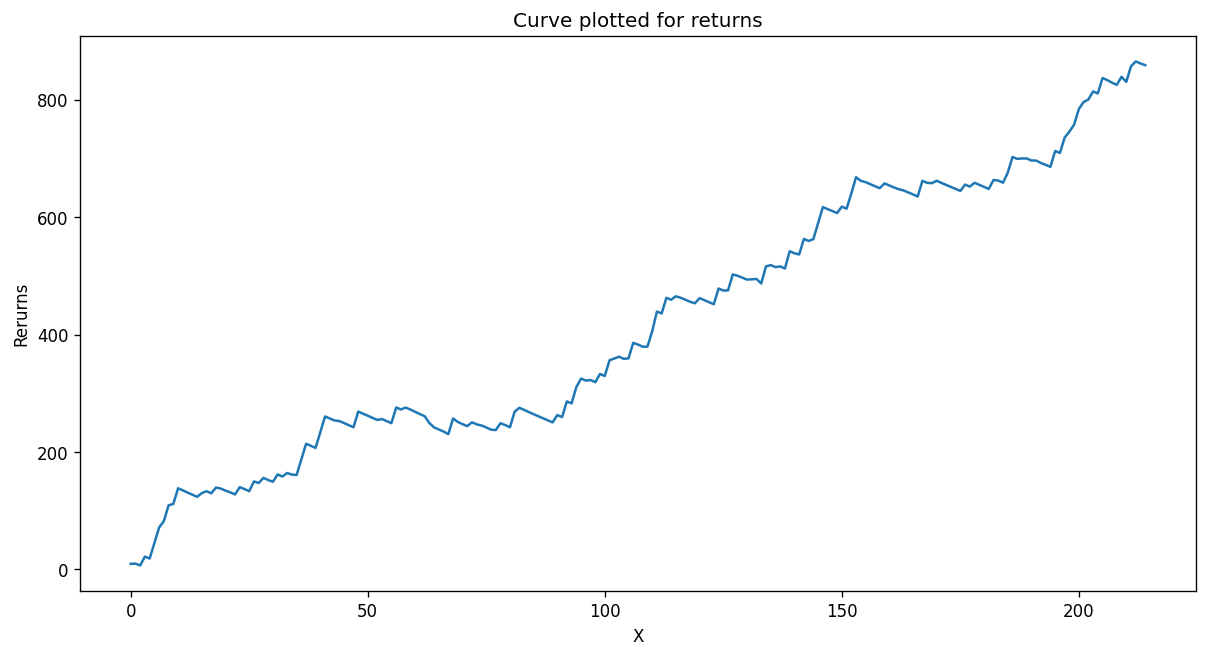

In [42]:
copy_trades = trades.copy()
copy_trades['cum_sum'] = copy_trades['PnL'].cumsum()
X = np.array(range(0, len(copy_trades['cum_sum'])))
Y = copy_trades['cum_sum']
# Plotting the Graph
plt.plot(X, Y)
plt.title("Curve plotted for returns")
plt.xlabel("X")
plt.ylabel("Rerurns")
plt.show()